In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
import matplotlib.pyplot as plt



(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()


train_images = train_images.astype("float32") / 255.0
test_images  = test_images.astype("float32")  / 255.0
train_images = train_images[..., np.newaxis]
test_images  = test_images[..., np.newaxis]


SUBSET = 10_000
SEED = 42
rng = np.random.default_rng(SEED)
idx = rng.choice(len(train_images), size=SUBSET, replace=False)
train_images_small = train_images[idx]
train_labels_small = train_labels[idx]


model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


EPOCHS = 3
model.fit(
    train_images_small, train_labels_small,
    batch_size=256,
    epochs=EPOCHS,
    validation_data=(test_images, test_labels),
    verbose=2
)


test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"\n✅ Test accuracy after {EPOCHS} epochs: {test_acc:.4f}")

MODEL_PATH = "mnist_cnn.h5"
model.save(MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")


def _prepare_array(img_arr: np.ndarray) -> np.ndarray:
    if img_arr.shape != (28, 28):
        raise ValueError("Input array must be 28×28.")
    img_arr = img_arr.astype("float32") / 255.0
    img_arr = img_arr.reshape(1, 28, 28, 1)
    return img_arr

def _load_and_prepare_image(path: str) -> np.ndarray:
    with Image.open(path) as im:
        im = im.convert("L")
        im = im.resize((28, 28), Image.LANCZOS)
        img_arr = np.array(im)
    return _prepare_array(img_arr)

def predict_digit(img_source, model_or_path=model):
    mdl = tf.keras.models.load_model(model_or_path) if isinstance(model_or_path, str) else model_or_path
    if isinstance(img_source, str):
        x = _load_and_prepare_image(img_source)
    elif isinstance(img_source, np.ndarray):
        x = _prepare_array(img_source)
    else:
        raise TypeError("img_source must be a NumPy array or file path.")
    probs = mdl.predict(x, verbose=0)[0]
    digit = int(np.argmax(probs))
    confidence = float(probs[digit])
    return digit, confidence

def predict_single_image(path, model_or_path=model, show=True):
    with Image.open(path) as im_orig:
        im_gray = im_orig.convert("L")
        if show:
            plt.imshow(im_orig, cmap="gray")
            plt.title("Input Image")
            plt.axis("off")
            plt.show()
        im_resized = im_gray.resize((28, 28), Image.LANCZOS)
        img_arr = np.array(im_resized)
    digit, conf = predict_digit(img_arr, model_or_path)
    print(f"🔢 Predicted digit: {digit} with confidence: {conf:.2%}")
    return digit, conf



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
40/40 - 14s - 346ms/step - accuracy: 0.6981 - loss: 1.1162 - val_accuracy: 0.8227 - val_loss: 0.5590
Epoch 2/3
40/40 - 19s - 470ms/step - accuracy: 0.8865 - loss: 0.3707 - val_accuracy: 0.9148 - val_loss: 0.2686
Epoch 3/3
40/40 - 20s - 495ms/step - accuracy: 0.9296 - loss: 0.2273 - val_accuracy: 0.9500 - val_loss: 0.1652



✅ Test accuracy after 3 epochs: 0.9500
✅ Model saved to mnist_cnn.h5


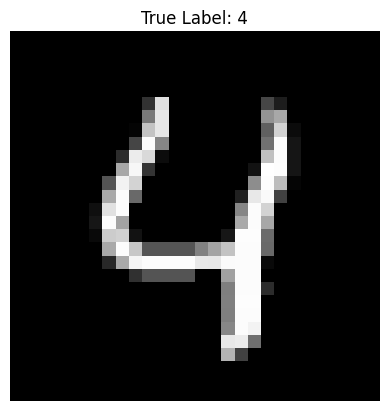


🧪 Test image: predicted 4 (98.97% confidence), true label 4


In [11]:

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    index = 4
    image = test_images[index].squeeze()
    label = test_labels[index]

    # Show the image
    plt.imshow(image, cmap="gray")
    plt.title(f"True Label: {label}")
    plt.axis("off")
    plt.show()

    # Predict
    digit, conf = predict_digit(image * 255.0)
    print(f"\n🧪 Test image: predicted {digit} ({conf:.2%} confidence), true label {label}")
